In [1]:
import xarray as xr
import numpy as np
from minisom import MiniSom
import pandas as pd
from sklearn.preprocessing import RobustScaler
import pprint
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec 
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
import matplotlib.gridspec as gridspec 
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

from som_2var_training import read_and_transform, build_scaler, train_som

In [2]:
ds_tor = xr.open_dataset('./Datasets/pper_tor_1979_2023.nc')
ds_wind = xr.open_dataset('./Datasets/pper_wind_1979_2023.nc')
ds_hail = xr.open_dataset('./Datasets/pper_hail_1979_2023.nc')

In [3]:
prefs = {'filename': "./Datasets/spring_z500_td2m.nc", 
         'var1': 'z500', 'var2': 'td2m', 'wlon': 220, 'elon': 305, 'nlat': 55, 'slat': 20, 
         'som_config': {'x': 2, 'y': 3, 'sigma': 0.5, 'random_seed': 42},
         'som_train': {'num_iteration': 10000, 'random_order': True, 'verbose': True}}

trained_som, trained_scaler, train_info, xr_data = train_som(prefs)


current model configuration
{'input_len': 24282, 'random_seed': 42, 'sigma': 0.5, 'x': 2, 'y': 3}
current training configuration
{'data': array([[-0.712504  , -0.7123801 , -0.6898653 , ..., -4.009091  ,
        -4.076801  , -3.9931393 ],
       [-0.04435258, -0.08802831, -0.11636167, ..., -0.56666666,
        -0.74240017, -0.80274475],
       [-0.02644878, -0.02472697, -0.01121567, ..., -1.8121206 ,
        -1.968     , -2.1543741 ],
       ...,
       [ 0.        , -0.01418204, -0.01238249, ..., -0.88181764,
        -1.0400007 , -1.1835339 ],
       [ 0.97334176,  0.9745891 ,  0.9802888 , ...,  0.2939392 ,
         0.33599955,  0.36020532],
       [ 1.0152553 ,  1.0167688 ,  1.0188868 , ...,  0.6030304 ,
         0.71360034,  0.8233274 ]], dtype=float32),
 'num_iteration': 10000,
 'random_order': True,
 'verbose': True}
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 98.30520431640268


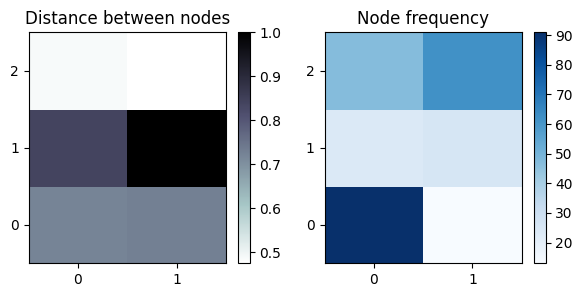

In [4]:
plt.rcParams['figure.figsize'] = 7, 3
x = [x+0.5 for x in range(train_info['som_config']['x'])]
y = [y+0.5 for y in range(train_info['som_config']['y'])]

ax = plt.subplot(1, 2, 1)
ax.set_yticks(y, range(train_info['som_config']['y']))
ax.set_xticks(x, range(train_info['som_config']['x']))
ax.set_title("Distance between nodes")
mmp = ax.pcolor(trained_som.distance_map().T, cmap='bone_r')
plt.colorbar(mmp, ax=ax)

ax = plt.subplot(1, 2, 2)
ax.set_yticks(y, range(train_info['som_config']['y']))
ax.set_xticks(x, range(train_info['som_config']['x']))
ax.set_title("Node frequency")
mmp = ax.pcolor(trained_som.activation_response(train_info['som_train']['data']).T, cmap='Blues')
plt.colorbar(mmp, ax=ax)

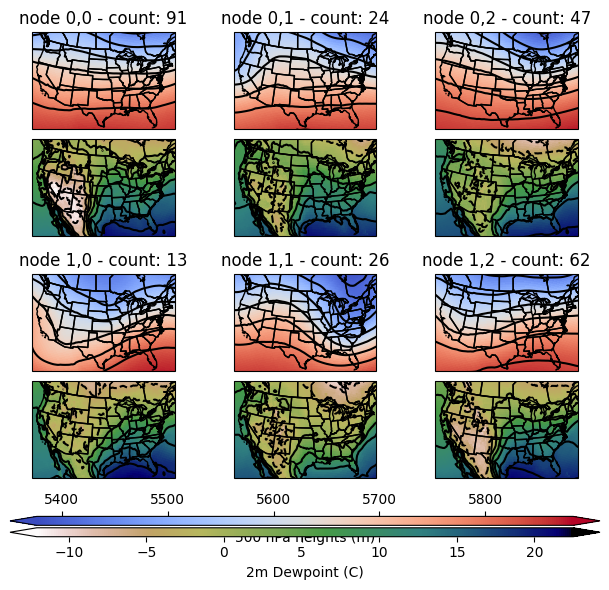

In [5]:
win_map = trained_som.win_map(train_info['som_train']['data'])

z500_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][:12141],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

z500_frequencies = trained_som.activation_response(train_info['som_train']['data']).flatten()


pwat_avg_data = [
    np.reshape(
        trained_scaler.inverse_transform([np.mean(win_map[node], axis=0)])[0][12141:],
        (len(xr_data.lat), len(xr_data.lon))
    )
    for node in sorted(win_map.keys())
]

pwat_frequencies = trained_som.activation_response(train_info['som_train']['data']).flatten()


length, width = prefs['som_config']['x'], prefs['som_config']['y']
# np.reshape(z500_avg_data, (4, 4, 71, 171))
# np.reshape(pwat_avg_data, (4, 4, 71, 171))

vmin_z500 = np.min(z500_avg_data)
vmax_z500 = np.max(z500_avg_data)
norm_z500 = mcolors.Normalize(vmin= vmin_z500, vmax= vmax_z500)

vmin_pwat = np.min(pwat_avg_data)
vmax_pwat = np.max(pwat_avg_data)
norm_pwat = mcolors.Normalize(vmin=vmin_pwat, vmax=vmax_pwat)


fig = plt.figure(figsize=(3.1 * length, 2 * width))


outer = GridSpec(nrows= length + 1, ncols= width, figure= fig, height_ratios = [1] * length + [0.1])

for i in range(length):
    for j in range(width):
        node_idx = i * width + j
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i, j], hspace= 0.1, wspace= 0.05)
        
        ax_z500 = fig.add_subplot(inner[0,0], projection= ccrs.LambertConformal())
        ax_z500.set_title(f'node {i},{j} - count: {int(pwat_frequencies[node_idx])}')
        ax_z500.set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380, xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
        zcm = ax_z500.pcolormesh(xr_data.lon, xr_data.lat, z500_avg_data[node_idx], cmap= 'coolwarm', transform= ccrs.PlateCarree())
        zct = ax_z500.contour(xr_data.lon, xr_data.lat, z500_avg_data[node_idx], colors= 'k', transform= ccrs.PlateCarree())
        ax_z500.add_feature(cfeature.BORDERS)
        ax_z500.add_feature(cfeature.STATES)
        
        ax_pwat = fig.add_subplot(inner[1, 0], projection= ccrs.LambertConformal())
        ax_pwat.set_extent([xr_data.lon.values.min() - 340, xr_data.lon.values.max() - 380, xr_data.lat.values.min() + 3, xr_data.lat.values.max() - 3])
        pcm = ax_pwat.pcolormesh(xr_data.lon, xr_data.lat, pwat_avg_data[node_idx], cmap= 'gist_earth_r', transform= ccrs.PlateCarree())
        pct = ax_pwat.contour(xr_data.lon, xr_data.lat, pwat_avg_data[node_idx], colors= 'k', transform= ccrs.PlateCarree())
        ax_pwat.add_feature(cfeature.BORDERS)
        ax_pwat.add_feature(cfeature.STATES)


cax_inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec= outer[-1, :])        
cax_z500 = fig.add_subplot(cax_inner[0, 0])
cax_pwat = fig.add_subplot(cax_inner[1, 0])

cb_z500 = fig.colorbar(zcm, cax= cax_z500, orientation= 'horizontal', extend= 'both')
cb_z500.ax.xaxis.set_ticks_position('top')
cb_z500.ax.xaxis.set_ticks_position('top')
cb_z500.ax.tick_params(labeltop= True, labelbottom= False)
cb_z500.set_label('500 hPa heights (m)')
fig.colorbar(pcm, cax= cax_pwat, orientation= 'horizontal', extend= 'both', label= '2m Dewpoint (C)')
plt.tight_layout()
plt.savefig('./Figures/spring_z500_td2m.png', bbox_inches= 'tight')

In [6]:
win_map_idx = trained_som.win_map(train_info['som_train']['data'], return_indices = True)

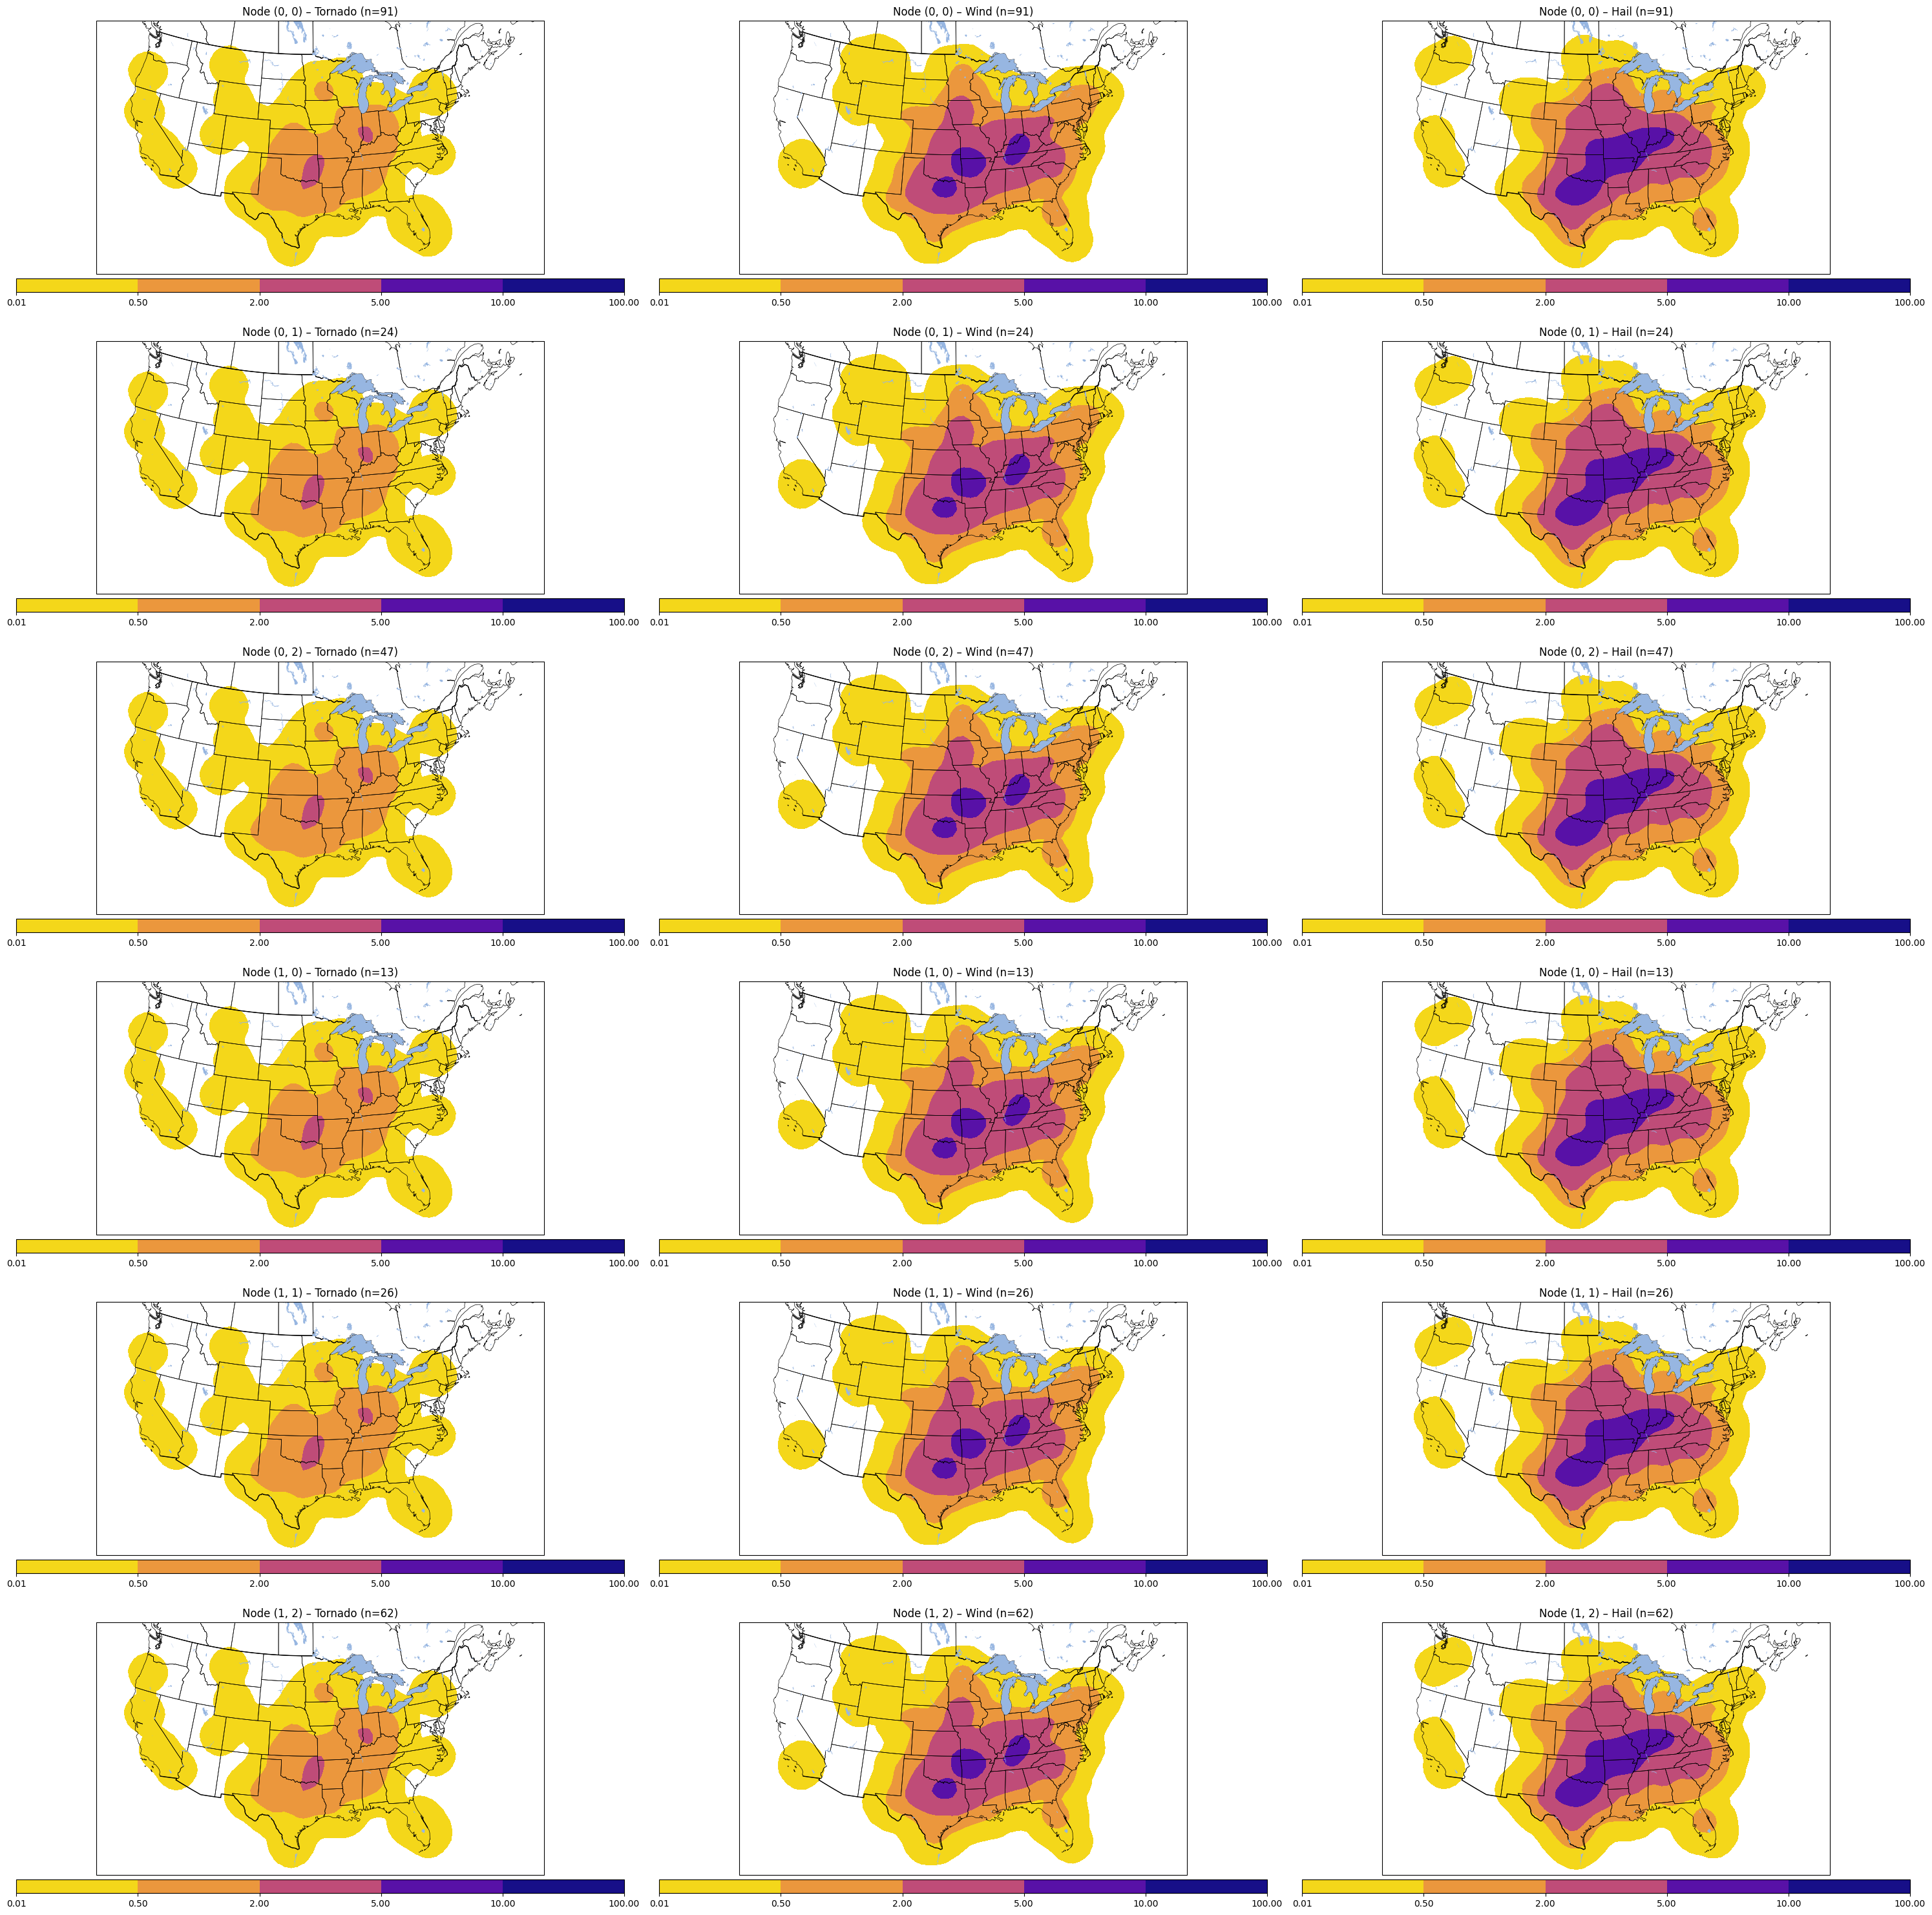

In [13]:
colors = [
    "#f4d71a", 
    "#eb973d",  
    "#bf4c78", 
    "#5811a7", 
    "#170f88", 
]

levels = [0.01, 0.5, 2.0, 5.0, 10.0, 100]  
               
nodes = list(sorted(win_map_idx.keys()))
nrows = len(nodes)
ncols = 3  # tor, wind, hail

plt.rcParams['figure.figsize'] = (30, 5 * nrows)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={'projection': ccrs.LambertConformal()},
)

if nrows == 1:
    axes = np.expand_dims(axes, 0)

for row, node in enumerate(nodes):
    idx_list = win_map_idx[node]
    nodesel = xr_data.isel(time=idx_list)

    # shift back a day bc pper is 12z-12z, and dataset is 0z
    time_sel = (nodesel.time - np.timedelta64(1, 'D')).astype('datetime64[D]').astype(str)

    ds_tor_sel  = ds_tor.sel(time=time_sel,  method='nearest')
    ds_wind_sel = ds_wind.sel(time=time_sel, method='nearest')
    ds_hail_sel = ds_hail.sel(time=time_sel, method='nearest')

    tor_mean  = ds_tor_sel.p_perfect_tor.mean(dim="time")
    wind_mean = ds_wind_sel.p_perfect_wind.mean(dim="time")
    hail_mean = ds_hail_sel.p_perfect_hail.mean(dim="time")


    ax1, ax2, ax3 = axes[row]

    for ax in (ax1, ax2, ax3):
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)
        ax.add_feature(cfeature.LAKES)
        ax.set_extent([-122, -67, 20, 50])

    count = len(idx_list)
    ax1.set_title(f'Node {node} – Tornado (n={count})')
    ax2.set_title(f'Node {node} – Wind (n={count})')
    ax3.set_title(f'Node {node} – Hail (n={count})')

    cm_tor = ax1.contourf(
        ds_tor.lon, ds_tor.lat, tor_masked,
        colors=colors, levels=levels, transform=ccrs.PlateCarree()
    )
    cm_wind = ax2.contourf(
        ds_wind.lon, ds_wind.lat, wind_masked,
        colors=colors, levels=levels, transform=ccrs.PlateCarree()
    )
    cm_hail = ax3.contourf(
        ds_hail.lon, ds_hail.lat, hail_masked,
        colors=colors, levels=levels, transform=ccrs.PlateCarree()
    )

    cb1 = plt.colorbar(cm_tor,  orientation='horizontal', ax=ax1, pad=0.015, aspect=45)
    cb2 = plt.colorbar(cm_wind, orientation='horizontal', ax=ax2, pad=0.015, aspect=45)
    cb3 = plt.colorbar(cm_hail, orientation='horizontal', ax=ax3, pad=0.015, aspect=45)

plt.tight_layout()
#plt.savefig('./Figures/spring_td2m_z500_pper.png', dpi=150)